계획
- 베이스라인 모델을 정하고
- Sentencepiece를 통해 tokenizer로 바꾸기
- sentencePiece모델의 하이퍼파라미터 바꾸기

In [3]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz

--2025-08-27 06:46:44--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2025-08-27 06:46:44--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-e

In [14]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [konlpy]2m2/3 [konlpy]


In [86]:
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import konlpy
%matplotlib inline
print(torch.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

2.7.1+cu118
2.2.6
3.10.3
0.6.0


# 데이터셋 EDA

- 사용할 데이터: 네이버 영화리뷰 감정 분석 태스크(https://github.com/e9t/nsmc/)
- id, document, label로 구성됨
- 200K reviews in total
- ratings.txt: All 200K reviews
- ratings_test.txt: 50K reviews held out for testing
- ratings_train.txt: 150K reviews for training
- 모든 리뷰는 140자 미만

In [5]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!mv ratings_*.txt ~/work/sentiment_classification/naver_movie_data

--2025-08-28 02:39:44--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  6.38MB/s    in 2.2s    

2025-08-28 02:39:47 (6.38 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2025-08-28 02:39:47--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/octet

In [87]:
import pandas as pd
# 데이터를 읽어보기

train_df = pd.read_csv('/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_test.txt', sep='\t')

print("훈련 데이터 결측치:")
print(train_df.isnull().sum())

print("\n테스트 데이터 결측치:")
print(test_df.isnull().sum())

훈련 데이터 결측치:
id          0
document    5
label       0
dtype: int64

테스트 데이터 결측치:
id          0
document    3
label       0
dtype: int64


In [88]:
train_df = train_df.dropna(how='any')
test_df = test_df.dropna(how='any')

print("결측치 제거 후 훈련 데이터 결측치:")
print(train_df.isnull().sum())

print("\n결측치 제거 후 테스트 데이터 결측치:")
print(test_df.isnull().sum())

결측치 제거 후 훈련 데이터 결측치:
id          0
document    0
label       0
dtype: int64

결측치 제거 후 테스트 데이터 결측치:
id          0
document    0
label       0
dtype: int64


In [89]:
print("훈련 데이터 중복 확인:")
print(train_df.duplicated().sum())

print("\n테스트 데이터 중복 확인:")
print(test_df.duplicated().sum())

훈련 데이터 중복 확인:
0

테스트 데이터 중복 확인:
0


In [90]:
print("훈련 데이터 레이블 분포:")
print(train_df['label'].value_counts())

print("\n테스트 데이터 레이블 분포:")
print(test_df['label'].value_counts())

훈련 데이터 레이블 분포:
label
0    75170
1    74825
Name: count, dtype: int64

테스트 데이터 레이블 분포:
label
1    25171
0    24826
Name: count, dtype: int64


In [91]:
train_df['document_length'] = train_df['document'].apply(len)

print("훈련 데이터 리뷰 길이 분포 요약:")
print(train_df['document_length'].describe())

훈련 데이터 리뷰 길이 분포 요약:
count    149995.000000
mean         35.204527
std          29.531890
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: document_length, dtype: float64


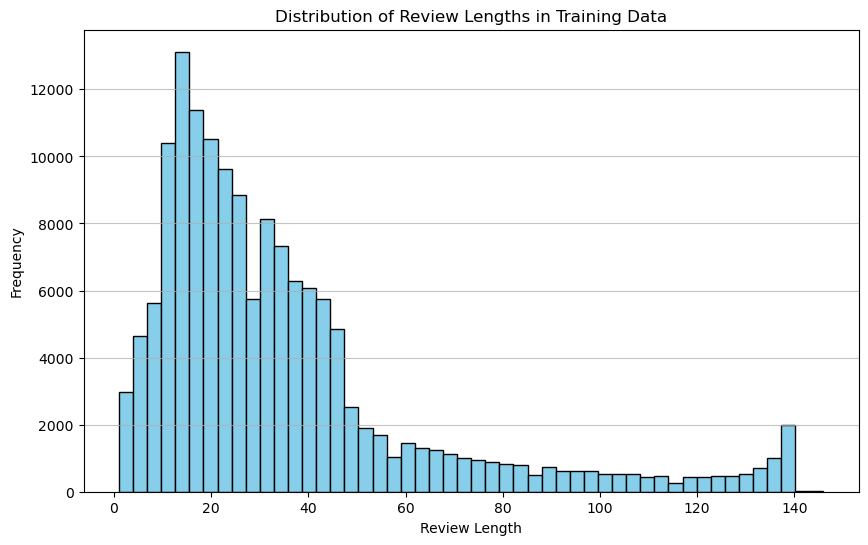

In [92]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_df['document_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths in Training Data')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
     

In [93]:
train_df = pd.read_csv('/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_test.txt', sep='\t')

print("훈련 데이터 헤드:")
display(train_df.head())

print("\n테스트 데이터 헤드:")
display(test_df.head())
     

훈련 데이터 헤드:


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1



테스트 데이터 헤드:


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# SentencePiece 설치 및 학습

SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 

In [13]:
!pip install sentencepiece

In [94]:
import sentencepiece as spm
import os

corpus_file = '/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt'

spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix='naver_movie',
    vocab_size=8000,
    model_type='bpe'
)
     

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt
  input_format: 
  model_prefix: naver_movie
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <

In [95]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('naver_movie.model')

X_train_encoded = train_df['document'].apply(lambda x: sp.encode_as_ids(str(x)))

X_test_encoded = test_df['document'].apply(lambda x: sp.encode_as_ids(str(x)))

y_train = train_df['label']
y_test = test_df['label']

print("Encoded training data (first 5):")
print(X_train_encoded.head())

print("\nEncoded test data (first 5):")
print(X_test_encoded.head())

print("\nTraining labels (first 5):")
print(y_train.head())

print("\nTest labels (first 5):")
print(y_test.head())

Encoded training data (first 5):
0                    [10, 1240, 3, 80, 2952, 51, 2563]
1    [1861, 12, 5943, 228, 1488, 6, 6600, 41, 6457,...
2    [35, 6417, 7994, 163, 4703, 504, 1420, 2163, 360]
3    [717, 6394, 6484, 370, 6479, 6878, 495, 5215, ...
4    [3212, 7215, 6966, 6418, 6402, 3833, 6598, 227...
Name: document, dtype: object

Encoded test data (first 5):
0                                          [1347, 547]
1    [3025, 6934, 7230, 6857, 6567, 7231, 6854, 725...
2    [1685, 8, 112, 314, 41, 2346, 6436, 4021, 18, ...
3    [164, 6393, 261, 772, 6423, 278, 804, 6546, 12...
4    [28, 6934, 6403, 182, 6458, 806, 155, 5993, 12...
Name: document, dtype: object

Training labels (first 5):
0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

Test labels (first 5):
0    1
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [96]:
from torch.utils.data import TensorDataset, DataLoader

encoded_lengths = X_train_encoded.apply(len)

#최대 문장길이 95%
max_sequence_length = int(encoded_lengths.quantile(0.95))
print(f"Determined maximum sequence length: {max_sequence_length}")

def pad_and_truncate(sequence, max_length, padding_value=0):
    if len(sequence) > max_length:
        return sequence[:max_length]
    elif len(sequence) < max_length:
        return sequence + [padding_value] * (max_length - len(sequence))
    else:
        return sequence

X_train_padded = X_train_encoded.apply(lambda x: pad_and_truncate(x, max_sequence_length))
X_test_padded = X_test_encoded.apply(lambda x: pad_and_truncate(x, max_sequence_length))

X_train_tensor = torch.tensor(X_train_padded.tolist(), dtype=torch.long)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded.tolist(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)

print("\nPadded training tensor shape:", X_train_tensor.shape)
print("Training labels tensor shape:", y_train_tensor.shape)
print("Padded test tensor shape:", X_test_tensor.shape)
print("Test labels tensor shape:", y_test_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTrain DataLoader created with batch size {batch_size}")
print(f"Test DataLoader created with batch size {batch_size}")

Determined maximum sequence length: 52

Padded training tensor shape: torch.Size([150000, 52])
Training labels tensor shape: torch.Size([150000])
Padded test tensor shape: torch.Size([50000, 52])
Test labels tensor shape: torch.Size([50000])

Train DataLoader created with batch size 64
Test DataLoader created with batch size 64


In [97]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, text):
        embedded = self.embedding(text)  # (batch, seq_len, embedding_dim)
        output, (hidden, cell) = self.rnn(embedded)  
        
        # hidden: (num_layers * num_directions, batch, hidden_dim)
        hidden = hidden[-1]  # 마지막 layer의 hidden state만 사용 (batch, hidden_dim)

        output = self.fc(hidden)  # (batch, 1)
        return torch.sigmoid(output)

vocab_size = sp.get_piece_size()
embedding_dim = 100
hidden_dim = 128

model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim)

print(model)

SentimentClassifier(
  (embedding): Embedding(8000, 100)
  (rnn): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [98]:
import torch.optim as optim

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)
print("Model moved to device.")

Using device: cuda
Model moved to device.


In [99]:
model.train()

num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.5768
Epoch [2/10], Loss: 0.3455
Epoch [3/10], Loss: 0.2912
Epoch [4/10], Loss: 0.2490
Epoch [5/10], Loss: 0.2051
Epoch [6/10], Loss: 0.1626
Epoch [7/10], Loss: 0.1257
Epoch [8/10], Loss: 0.0993
Epoch [9/10], Loss: 0.0836
Epoch [10/10], Loss: 0.0698


In [100]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        outputs = model(batch_X)

        predicted_labels = (outputs >= 0.5).long()

        correct_predictions += (predicted_labels == batch_y.long()).sum().item()
        total_samples += batch_y.size(0)

accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy:.4f}")
     

Test Accuracy: 0.8413


In [101]:
import sentencepiece as spm

def sp_tokenize(text):
    """
    Tokenizes input text using the trained SentencePiece model.

    Args:
        text (str): The input text string.

    Returns:
        list: A list of token IDs.
    """
    if not isinstance(text, str):
        text = str(text)
    return sp.encode_as_ids(text)

# Example usage:
sample_text = "안녕하세요, SentencePiece 토큰화 테스트입니다."
token_ids = sp_tokenize(sample_text)
print(f"Original text: {sample_text}")
print(f"Token IDs: {token_ids}")


Original text: 안녕하세요, SentencePiece 토큰화 테스트입니다.
Token IDs: [52, 7324, 3058, 6425, 1467, 4996, 6695, 4996, 6840, 6682, 7231, 3920, 6840, 6682, 1044, 6936, 6390, 1542, 681, 247, 6374]


# 토크나이저 교체 실험

기준 베이스 모델:
- 토크나이저: SentencePiece(Vocab size = 8000, model_type = 'bpe')
- 최대문장길이: 0.95
- SentimentClassifier: LSTM
- epoch: 5 / 10
- criterion = nn.BCELoss()
- optimizer = optim.Adam(model.parameters(), lr=0.001)
- Test Accuracy: (epoch 5: 0.8525), (epoch 10: 0.8413)

실험은 크게 3가지 방향이 있다.
1. SentencePiece 실험: model_type, vocab_size 바꿔보기
2. KoNLPy와 비교 실험: Mecab으로 토크나이저를 교체해보기
3. 길이 제한 비교 실험: max_length 교체 혹은 min_length 추가

## SentencePiece 실험

1. model_type을 unigram으로 교체해본다.
2. model_type 2개 중에 성능이 좋은 type으로 vocab_size를 16,000으로 바꿔본다.

In [102]:
import sentencepiece as spm
import os

corpus_file = '/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt'

spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix='SP_test',
    vocab_size=8000,
    model_type='unigram' # unigram으로 교체
)
     

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt
  input_format: 
  model_prefix: SP_test
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <

In [103]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('SP_test.model')

X_train_encoded = train_df['document'].apply(lambda x: sp.encode_as_ids(str(x)))

X_test_encoded = test_df['document'].apply(lambda x: sp.encode_as_ids(str(x)))

y_train = train_df['label']
y_test = test_df['label']

print("Encoded training data (first 5):")
print(X_train_encoded.head())

print("\nEncoded test data (first 5):")
print(X_test_encoded.head())

print("\nTraining labels (first 5):")
print(y_train.head())

print("\nTest labels (first 5):")
print(y_test.head())

Encoded training data (first 5):
0                     [70, 936, 9, 43, 1489, 68, 1990]
1    [2836, 11, 5938, 177, 1937, 42, 244, 65, 170, ...
2     [34, 393, 7876, 364, 5005, 539, 2683, 3183, 312]
3    [2920, 15, 214, 259, 7285, 3, 9, 5424, 1509, 1...
4    [3308, 3507, 3157, 171, 13, 3, 1660, 322, 3510...
Name: document, dtype: object

Encoded test data (first 5):
0                                          [3078, 333]
1    [3, 3250, 1113, 4101, 3164, 2803, 3776, 3376, ...
2    [1573, 38, 101, 418, 65, 123, 3651, 104, 4524,...
3    [3144, 16, 6662, 145, 631, 107, 11, 2811, 5746...
4    [31, 1113, 33, 267, 4334, 15, 250, 6106, 147, ...
Name: document, dtype: object

Training labels (first 5):
0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

Test labels (first 5):
0    1
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [104]:
model.train()

num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0635
Epoch [2/10], Loss: 0.0562
Epoch [3/10], Loss: 0.0500
Epoch [4/10], Loss: 0.0479
Epoch [5/10], Loss: 0.0437
Epoch [6/10], Loss: 0.0399
Epoch [7/10], Loss: 0.0410
Epoch [8/10], Loss: 0.0358
Epoch [9/10], Loss: 0.0349
Epoch [10/10], Loss: 0.0327


In [105]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        outputs = model(batch_X)

        predicted_labels = (outputs >= 0.5).long()

        correct_predictions += (predicted_labels == batch_y.long()).sum().item()
        total_samples += batch_y.size(0)

accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy:.4f}")
     

Test Accuracy: 0.8360


epoch5
- model_type: 'bpe'는 0.8525
- model_type: 'unigram'은 0.8391

epoch10
- model_type: 'bpe'는 0.8413
- model_type: 'unigram'은 0.8360

성능이 더 좋은 bpe 기준으로 vocab size를 16000으로 늘려보려 했다.
하지만, 16000이 맞춰지지 않는 것인지 학습 속도가 오래걸려서 10000으로 진행했다.

성능 낮은 탓이 epoch가 충분히 돌지 않아서인가? 했으나, 5와 10이 차이 없는 것으로 보아 이 다음부터는 5로 통일했다.

In [1]:
import sentencepiece as spm
import os

corpus_file = '/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt'

spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix='SP_test2',
    vocab_size=10000,
    model_type='bpe'
)
     

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt
  input_format: 
  model_prefix: SP_test2
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pa

In [19]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('SP_test2.model')

X_train_encoded = train_df['document'].apply(lambda x: sp.encode_as_ids(str(x)))

X_test_encoded = test_df['document'].apply(lambda x: sp.encode_as_ids(str(x)))

y_train = train_df['label']
y_test = test_df['label']

print("Encoded training data (first 5):")
print(X_train_encoded.head())

print("\nEncoded test data (first 5):")
print(X_test_encoded.head())

print("\nTraining labels (first 5):")
print(y_train.head())

print("\nTest labels (first 5):")
print(y_test.head())

Encoded training data (first 5):
0                    [10, 1240, 3, 80, 2952, 51, 2563]
1    [1861, 12, 5943, 228, 1488, 6, 8600, 41, 8457,...
2    [35, 8417, 9994, 163, 4703, 504, 1420, 2163, 360]
3    [717, 8394, 8484, 370, 8479, 8878, 495, 5215, ...
4    [3212, 9215, 8966, 8418, 8402, 3833, 8598, 227...
Name: document, dtype: object

Encoded test data (first 5):
0                                          [1347, 547]
1    [3025, 8934, 9230, 8857, 8567, 9231, 8854, 925...
2    [1685, 8, 112, 314, 41, 2346, 8436, 4021, 18, ...
3    [164, 8393, 261, 6951, 278, 804, 8546, 12, 219...
4    [28, 8934, 8403, 182, 8458, 806, 155, 5993, 12...
Name: document, dtype: object

Training labels (first 5):
0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

Test labels (first 5):
0    1
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [20]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.5562
Epoch [2/5], Loss: 0.3379
Epoch [3/5], Loss: 0.2867
Epoch [4/5], Loss: 0.2447
Epoch [5/5], Loss: 0.2015


In [21]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        outputs = model(batch_X)

        predicted_labels = (outputs >= 0.5).long()

        correct_predictions += (predicted_labels == batch_y.long()).sum().item()
        total_samples += batch_y.size(0)

accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy:.4f}")
     

Test Accuracy: 0.8500


- vocab size가 8000은 0.8525
- vocab size가 10000은 0.8500
큰 차이가 없었다.

## KoNLpy Mecab과 비교 실험

In [32]:
pip install -U mecab-python3 mecab-ko-dic konlpy jpype1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 2.8 MB/s  0:00:11m0:00:0100:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'mecab-ko-dic' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'mecab-ko-dic'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for mecab-ko-dic: filename=mecab_ko_dic-1.0.0-py3-none-any.whl size=33424434 sha256=1b6c9adff9efaf48bc1f97bdd8f929a1b7219ad7e8c41cf1fe275f64c69b5968
  Stored in directory: /home/jovyan/.cache/pip/wheels/38/b6/bb/e5c73805f8318db251a0a10b4a8becfb4c4e9e49a5b892761a
Successfully built mecab-ko-dic
Note: you may need to restart the kernel to use updated packages.


In [39]:
import MeCab, mecab_ko_dic
print("MeCab module:", MeCab.__file__)
tagger = MeCab.Tagger(f"-d {mecab_ko_dic.DICDIR}")
print(tagger.parse("이 영화 진짜 재밌다 ㅋㅋ"))  # 형태소 분석 결과가 나오면 정상


MeCab module: /opt/conda/lib/python3.12/site-packages/MeCab/__init__.py
이	MM,~명사,F,이,*,*,*,*
영화	NNG,*,F,영화,*,*,*,*
진짜	MAG,문장부사/양상부사,F,진짜,*,*,*,*
재밌	VA,*,T,재밌,*,*,*,*
다	EF,*,F,다,*,*,*,*
ㅋㅋ	UNKNOWN,*,*,*,*,*,*,*
EOS



In [45]:
from collections import Counter
import pandas as pd

# train_df, test_df: (id, document, label) 형태라고 가정
train_df = train_df.dropna(subset=['document']).reset_index(drop=True)
test_df  = test_df.dropna(subset=['document']).reset_index(drop=True)

# 토큰화
train_tokens = [tokenize_mecab(x) for x in train_df['document']]
test_tokens  = [tokenize_mecab(x) for x in test_df['document']]

# vocab 생성
MIN_FREQ = 2          # 너무 희귀한 토큰 제거
MAX_VOCAB = 20000     # (선택) 상한; None이면 무제한

counter = Counter()
for toks in train_tokens:
    counter.update(toks)

specials = ["<pad>", "<unk>"]
tokens = [t for t, f in counter.items() if f >= MIN_FREQ]
tokens.sort(key=lambda t: (-counter[t], t))

if MAX_VOCAB is not None:
    tokens = tokens[:max(0, MAX_VOCAB - len(specials))]

stoi = {tok:i for i, tok in enumerate(specials + tokens)}
itos = {i:tok for tok,i in stoi.items()}

PAD_ID = stoi["<pad>"]
UNK_ID = stoi["<unk>"]
VOCAB_SIZE = len(stoi)
print("VOCAB_SIZE:", VOCAB_SIZE)


VOCAB_SIZE: 20000


In [50]:
def encode(tokens, stoi, unk_id):
    return [stoi.get(t, unk_id) for t in tokens]

X_train_encoded = [encode(t, stoi, UNK_ID) for t in train_tokens]
X_test_encoded  = [encode(t, stoi, UNK_ID) for t in test_tokens]

# 길이 95% 분위수로 max_len 결정
import numpy as np
lengths = np.array([len(x) for x in X_train_encoded])
max_len = int(np.quantile(lengths, 0.95))
print("max_len (95%):", max_len)

def pad_trunc(seq, max_len, pad_id):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_id] * (max_len - len(seq))

X_train_padded = [pad_trunc(x, max_len, PAD_ID) for x in X_train_encoded]
X_test_padded  = [pad_trunc(x, max_len, PAD_ID) for x in X_test_encoded]


max_len (95%): 55


In [51]:
import torch
from torch.utils.data import TensorDataset, DataLoader

y_train = train_df['label'].astype(int).tolist()
y_test  = test_df['label'].astype(int).tolist()

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # BCEWithLogitsLoss 쓰려면 float
X_test_tensor  = torch.tensor(X_test_padded,  dtype=torch.long)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test_tensor),  batch_size=64, shuffle=False)

# 모델 생성 시 vocab_size를 새로 반영!
embedding_dim = 100
hidden_dim = 128
model = SentimentClassifier(vocab_size=VOCAB_SIZE, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
print(model)


SentimentClassifier(
  (embedding): Embedding(20000, 100)
  (rnn): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [56]:
PAD_ID = 0 
model.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_ID).to(device)
model.to(device)

SentimentClassifier(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (rnn): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [57]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [58]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.6923
Epoch [2/5], Loss: 0.5442
Epoch [3/5], Loss: 0.3267
Epoch [4/5], Loss: 0.2734
Epoch [5/5], Loss: 0.2323


In [59]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        outputs = model(batch_X)

        predicted_labels = (outputs >= 0.5).long()

        correct_predictions += (predicted_labels == batch_y.long()).sum().item()
        total_samples += batch_y.size(0)

accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy:.4f}")
     

Test Accuracy: 0.8616


test accuracy가 0.8616으로 제일 높게 나타났다.

## 길이 조절 실험

1. max_len을 0.98로 조정해본다.

In [62]:
max_len = int(np.quantile(lengths, 0.98))
print("max_len (98%):", max_len)

def pad_trunc(seq, max_len, pad_id):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_id] * (max_len - len(seq))

X_train_padded = [pad_trunc(x, max_len, PAD_ID) for x in X_train_encoded]
X_test_padded  = [pad_trunc(x, max_len, PAD_ID) for x in X_test_encoded]


max_len (98%): 68


In [63]:
def pad_trunc(seq, max_len, pad_id):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_id] * (max_len - len(seq))

X_train_padded = [pad_trunc(x, max_len, PAD_ID) for x in X_train_encoded]
X_test_padded  = [pad_trunc(x, max_len, PAD_ID) for x in X_test_encoded]

In [68]:
import torch
from torch.utils.data import TensorDataset, DataLoader

y_train = train_df['label'].astype(int).tolist()
y_test  = test_df['label'].astype(int).tolist()

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # BCEWithLogitsLoss 쓰려면 float
X_test_tensor  = torch.tensor(X_test_padded,  dtype=torch.long)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test_tensor),  batch_size=64, shuffle=False)


In [69]:
# 1) 모델 새로 만들기 (MeCab vocab)
VOCAB_SIZE = len(stoi)
embedding_dim = 100
hidden_dim = 128
PAD_ID = 0

model = SentimentClassifier(VOCAB_SIZE, embedding_dim, hidden_dim)

# 2) padding_idx 반영
model.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim, padding_idx=PAD_ID)

# 3) 장치로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4) 옵티마이저/로스는 이동 후 다시 만들기
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [70]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.6830
Epoch [2/5], Loss: 0.6398
Epoch [3/5], Loss: 0.6114
Epoch [4/5], Loss: 0.4461
Epoch [5/5], Loss: 0.3540


In [71]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        outputs = model(batch_X)

        predicted_labels = (outputs >= 0.5).long()

        correct_predictions += (predicted_labels == batch_y.long()).sum().item()
        total_samples += batch_y.size(0)

accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy:.4f}")
     

Test Accuracy: 0.8418


# 결론

- 베이스 모델(SentencePiece, bpe, vocab 8000): 0.8525
- SentencePiece(unigram, vocab 8000):0.8391
- SentencePiece(bpe, vocab 10000): 0.8500
- Mecab(max_len 95%): 0.8616
- Mecab(max_len 98%): 0.8418

# 회고

- Mecab이 성능이 제일 좋았다.
- max_len이 98%로 늘면, 패딩도 늘어나고, RNN 모델을 썼기 때문에 길이가 길어지면서 정보 손실 이슈가 생기는 것 같다.
- SentencePiece 결과와 큰 차이가 없었는데, 중복되는 말('ㅋㅋㅋ')이나 특수부호 전처리를 해주면 더 높아질 것이 기대된다. (추가실험 필요)
- 추가실험 결과가 만약 큰 차이가 없다면, 한국어 처리 시에는 subword기반보다 형태소 기반이 더 적절하다는 결론을 내릴 수 있을 것 같다.

# 추가실험

데이터에 중복되는 말과 특수부호 전처리를 하고, 베이스 모델을 다시 진행해보자.

In [74]:
import pandas as pd
# 데이터를 읽어보기

train_df = pd.read_csv('/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt', sep='\t')
test_df = pd.read_csv('/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_test.txt', sep='\t')

print("훈련 데이터 결측치:")
print(train_df.isnull().sum())

print("\n테스트 데이터 결측치:")
print(test_df.isnull().sum())

훈련 데이터 결측치:
id          0
document    5
label       0
dtype: int64

테스트 데이터 결측치:
id          0
document    3
label       0
dtype: int64


In [75]:
train_df = train_df.dropna(how='any')
test_df = test_df.dropna(how='any')

print("결측치 제거 후 훈련 데이터 결측치:")
print(train_df.isnull().sum())

print("\n결측치 제거 후 테스트 데이터 결측치:")
print(test_df.isnull().sum())

결측치 제거 후 훈련 데이터 결측치:
id          0
document    0
label       0
dtype: int64

결측치 제거 후 테스트 데이터 결측치:
id          0
document    0
label       0
dtype: int64


In [76]:
print("훈련 데이터 중복 확인:")
print(train_df.duplicated().sum())

print("\n테스트 데이터 중복 확인:")
print(test_df.duplicated().sum())

훈련 데이터 중복 확인:
0

테스트 데이터 중복 확인:
0


In [77]:
print("훈련 데이터 레이블 분포:")
print(train_df['label'].value_counts())

print("\n테스트 데이터 레이블 분포:")
print(test_df['label'].value_counts())

훈련 데이터 레이블 분포:
label
0    75170
1    74825
Name: count, dtype: int64

테스트 데이터 레이블 분포:
label
1    25171
0    24826
Name: count, dtype: int64


In [78]:
train_df['document_length'] = train_df['document'].apply(len)

print("훈련 데이터 리뷰 길이 분포 요약:")
print(train_df['document_length'].describe())

훈련 데이터 리뷰 길이 분포 요약:
count    149995.000000
mean         35.204527
std          29.531890
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: document_length, dtype: float64


In [80]:
import sentencepiece as spm

corpus_file = '/home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt'

spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix='SP_test3',
    model_type='bpe',           # baseline
    vocab_size=8000,            # baseline
    pad_id=0, unk_id=1, bos_id=-1, eos_id=-1,   # ← PAD=0로 고정
    character_coverage=1.0,     # 한글 권장
    user_defined_symbols=["ㅋㅋ","ㅎㅎ","ㅠㅠ","ㅜㅜ","!!","??","?!","…","^^"],  # 구어체 신호 보존
    shuffle_input_sentence=True
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/jovyan/work/sentiment_classification/naver_movie_data/ratings_train.txt
  input_format: 
  model_prefix: SP_test3
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: ㅋㅋ
  user_defined_symbols: ㅎㅎ
  user_defined_symbols: ㅠㅠ
  user_defined_symbols: ㅜㅜ
  user_defined_symbols: !!
  user_defined_symbols: ??
  user_defined_symbols: ?!
  user_defined_symbols: …
  user_defined_symbols: ^^
  required_chars: 
  byte_fallback: 0
  vocabulary_output_pi

In [81]:
import sentencepiece as spm
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import re

# (선택) 가벼운 정규화: 반복 문자/부호 축약
_norm = [
    (re.compile(r'(ㅋ){2,}'),'ㅋㅋ'),
    (re.compile(r'(ㅎ){2,}'),'ㅎㅎ'),
    (re.compile(r'(ㅠ){2,}'),'ㅠㅠ'),
    (re.compile(r'(ㅜ){2,}'),'ㅜㅜ'),
    (re.compile(r'!{2,}'),'!!'),
    (re.compile(r'\?{2,}'),'??'),
    (re.compile(r'(\.{3,}|…{2,})'),'…'),
]
def normalize_kor(t):
    if not isinstance(t,str): return ""
    for p,r in _norm: t = p.sub(r,t)
    return re.sub(r'\s+',' ',t).strip()

sp = spm.SentencePieceProcessor(model_file='SP_test3.model')
PAD_ID, UNK_ID, VOCAB_SIZE = sp.pad_id(), sp.unk_id(), sp.get_piece_size()

def sp_encode(text):  # 정규화 on/off는 여기서 결정
    return sp.encode(normalize_kor(text), out_type=int)

# NaN 제거 후 인코딩
train_df = train_df.dropna(subset=['document']).reset_index(drop=True)
test_df  = test_df.dropna(subset=['document']).reset_index(drop=True)

X_train_encoded = [sp_encode(x) for x in train_df['document'].astype(str)]
X_test_encoded  = [sp_encode(x) for x in test_df['document'].astype(str)]
y_train = train_df['label'].astype(int).tolist()
y_test  = test_df['label'].astype(int).tolist()

# 인코딩 후 짧은 샘플은 필터링 (len>=3)
mask_tr = [len(x) >= 3 for x in X_train_encoded]
X_train_encoded = [x for x,m in zip(X_train_encoded, mask_tr) if m]
y_train         = [y for y,m in zip(y_train, mask_tr) if m]

# 95% 길이 컷
lengths = np.array([len(x) for x in X_train_encoded])
max_len = int(np.quantile(lengths, 0.95))
print("max_len(95%) =", max_len)

if PAD_ID == -1:
    PAD_ID = VOCAB_SIZE             # 새 PAD id로 마지막+1 사용
    VOCAB_SIZE_PAD = VOCAB_SIZE + 1
else:
    VOCAB_SIZE_PAD = VOCAB_SIZE

def pad_trunc(seq):
    return seq[:max_len] if len(seq)>=max_len else seq+[PAD_ID]*(max_len-len(seq))

X_train_pad = [pad_trunc(x) for x in X_train_encoded]
X_test_pad  = [pad_trunc(x) for x in X_test_encoded]

# 텐서/로더
Xtr = torch.tensor(X_train_pad, dtype=torch.long)
ytr = torch.tensor(y_train, dtype=torch.float32)
Xte = torch.tensor(X_test_pad,  dtype=torch.long)
yte = torch.tensor(y_test,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=64, shuffle=False)


max_len(95%) = 54


In [82]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, text):
        embedded = self.embedding(text)  # (batch, seq_len, embedding_dim)
        output, (hidden, cell) = self.rnn(embedded)  
        
        # hidden: (num_layers * num_directions, batch, hidden_dim)
        hidden = hidden[-1]  # 마지막 layer의 hidden state만 사용 (batch, hidden_dim)

        output = self.fc(hidden)  # (batch, 1)
        return torch.sigmoid(output)

vocab_size = sp.get_piece_size()
embedding_dim = 100
hidden_dim = 128

model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim)

print(model)

SentimentClassifier(
  (embedding): Embedding(8000, 100)
  (rnn): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [83]:
import torch.optim as optim

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)
print("Model moved to device.")

Using device: cuda
Model moved to device.


In [84]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.5710
Epoch [2/5], Loss: 0.3460
Epoch [3/5], Loss: 0.2956
Epoch [4/5], Loss: 0.2555
Epoch [5/5], Loss: 0.2133


In [85]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)

        outputs = model(batch_X)

        predicted_labels = (outputs >= 0.5).long()

        correct_predictions += (predicted_labels == batch_y.long()).sum().item()
        total_samples += batch_y.size(0)

accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy:.4f}")
     

Test Accuracy: 0.8492
